# GAN2_Loss U-net

## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
path = Path('data/smokeGAN')
path_hr = path/'targets'
path_lr = path/'crappy' #load the output of GAN1

In [3]:
il = ImageList.from_folder(path_hr)

In [4]:
# def resize_one(fn, i, path, size):
#     dest = path/fn.relative_to(path_hr)
#     dest.parent.mkdir(parents=True, exist_ok=True)
#     img = PIL.Image.open(fn)
#     targ_sz = resize_to(img, size, use_min=True)
#     img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
#     img.save(dest, quality=60)

In [5]:
# create smaller image sets the first time this nb is run
# sets = [(path_mr, 256)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

In [6]:
bs,size=16,256
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [7]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=1.05, flip_vert=True, max_lighting=0.1, max_warp=0.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [8]:
data = get_data(bs,size)

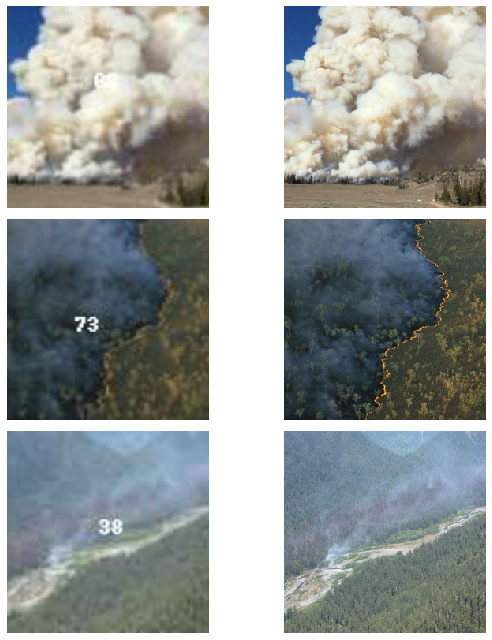

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=3, figsize=(9,9))

## Feature loss

In [10]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [11]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
gram_matrix(t)

tensor([[[0.1666, 0.1627, 0.1507],
         [0.1627, 0.1596, 0.1489],
         [0.1507, 0.1489, 0.1406]],

        [[0.1666, 0.1627, 0.1507],
         [0.1627, 0.1596, 0.1489],
         [0.1507, 0.1489, 0.1406]]])

In [13]:
base_loss = F.l1_loss

In [14]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [15]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [18]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


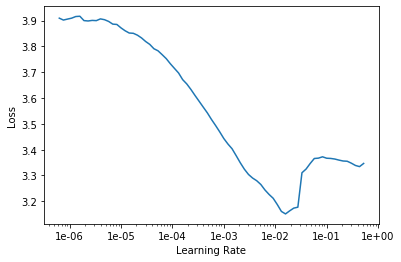

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 2e-3
epochs = 50

In [21]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=4, imgsize=5)

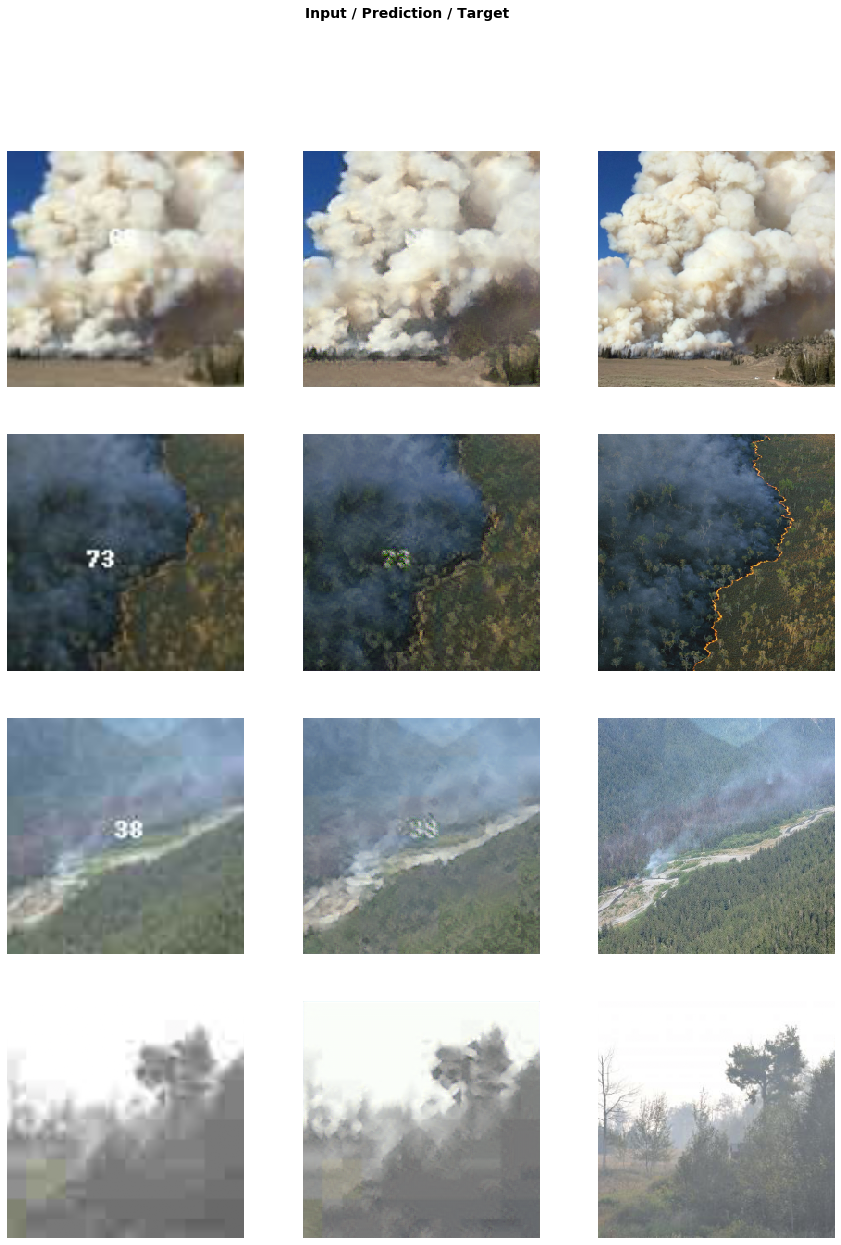

In [22]:
do_fit('1a', slice(lr*10))

In [23]:
learn.unfreeze()

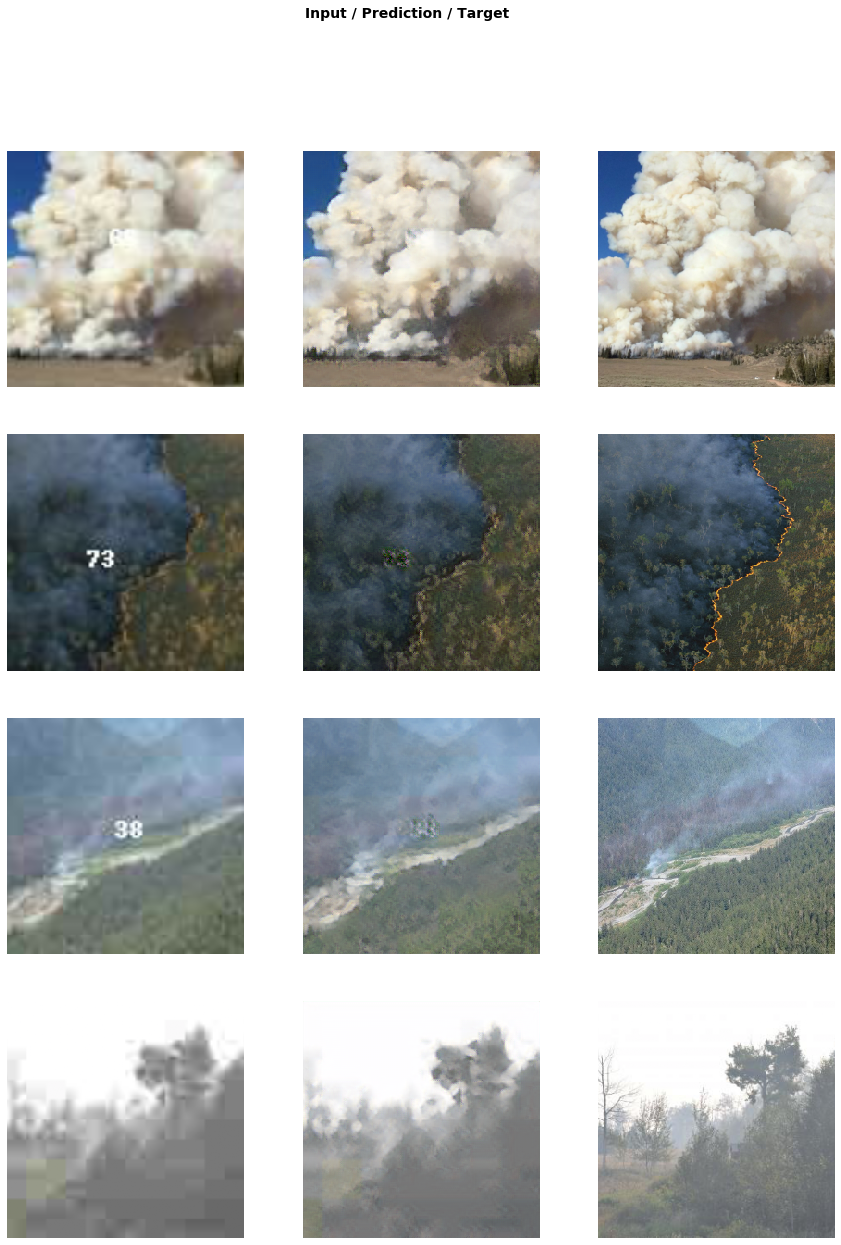

In [24]:
do_fit('1b', slice(1e-5,lr))

In [25]:
data = get_data(2,size*2) #go bigger

In [26]:
learn.data = data
learn.freeze()
gc.collect()

25370

In [27]:
learn.load('1b');

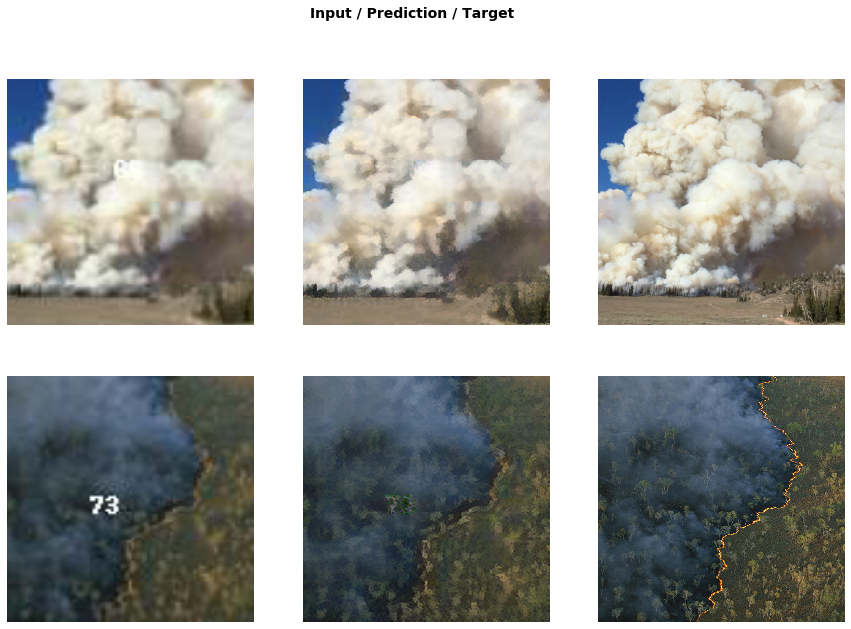

In [28]:
do_fit('2a')

In [29]:
learn.unfreeze()

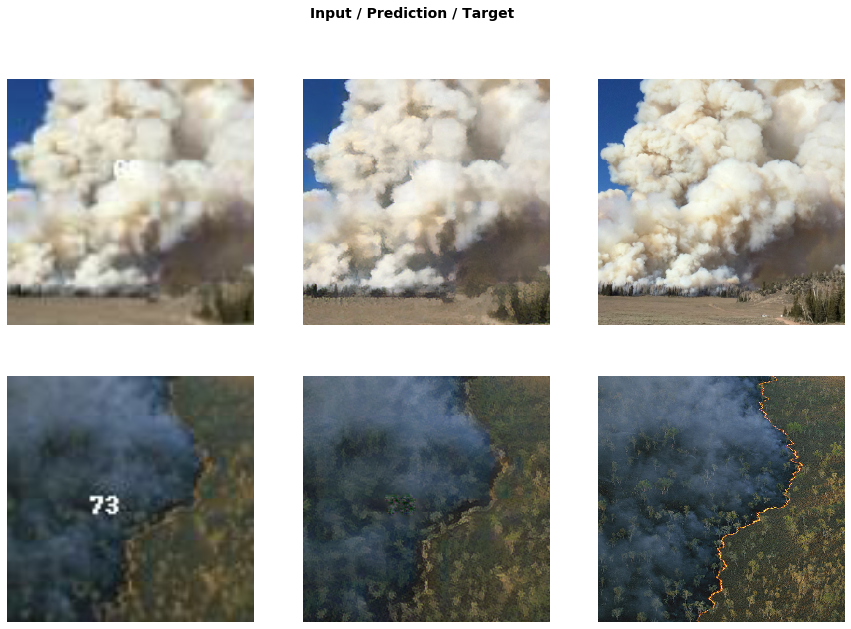

In [30]:
do_fit('2b', slice(1e-6,lr), pct_start=0.3)

## Save

In [31]:
name_PL = 'image_PL'
path_PL = path/name_PL
path_PL.mkdir(exist_ok=True)

In [32]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_PL/names[i].name)
            i += 1

In [33]:
save_preds(data.fix_dl)

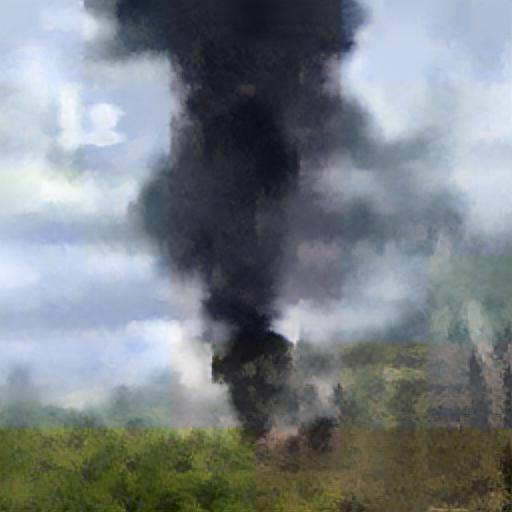

In [35]:
PIL.Image.open(path_PL.ls()[0])

# Test

In [ ]:
learn = None
gc.collect();

In [ ]:
256/320*1024

In [ ]:
256/320*1600

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
path_mr = path/'targets'

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('2b');

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

In [ ]:
img = open_image(fn); img.shape

In [ ]:
p,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
Image(img_hr).show(figsize=(18,15))